In [2]:
import os
import math
import pickle
import torch
import optuna
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

# 获取所有图像路径，递归查找
data = glob(r'/root/autodl-tmp/fingerprints/fingerprints/DB*/**/*.tif', recursive=True)
images = []

# 读取图像
def readImages(data):
    for img_path in data:
        print(f"尝试读取图像: {img_path}")
        try:
            img = Image.open(img_path).convert("RGB").resize((224, 224))
            images.append(np.array(img))
        except Exception as e:
            print(f"无法读取图像: {img_path}，错误信息: {e}")
    return images

images = readImages(data)
if len(images) == 0:
    raise ValueError("没有成功读取任何图像，请检查文件路径和格式。")

# 预处理图像数据
images_arr = np.asarray(images).astype('float32') / 255.0
if len(images_arr.shape) == 4:
    images_arr = np.transpose(images_arr, (0, 3, 1, 2))
else:
    raise ValueError("图像数组的形状不正确，检查读取步骤。")

# 划分训练集和验证集
train_X, valid_X, train_ground, valid_ground = train_test_split(
    images_arr, images_arr, test_size=0.2, random_state=13
)

# 转换为PyTorch张量
train_X = torch.tensor(train_X, dtype=torch.float32)
valid_X = torch.tensor(valid_X, dtype=torch.float32)
train_ground = torch.tensor(train_ground, dtype=torch.float32)
valid_ground = torch.tensor(valid_ground, dtype=torch.float32)

# 创建数据加载器
train_loader = DataLoader(TensorDataset(train_X, train_ground), batch_size=128, shuffle=True)
valid_loader = DataLoader(TensorDataset(valid_X, valid_ground), batch_size=128, shuffle=False)

尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/108_6.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_1.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/108_7.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_2.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/108_8.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_3.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/109_1.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_4.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/109_3.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_5.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/109_2.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_6.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/109_4.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_7.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/109_5

In [4]:
# 定义 RayLU 激活函数
class RayLU(nn.Module):
    def __init__(self, trial, seqFlag):
        super(RayLU, self).__init__()
        self.sigma = nn.Parameter(
            torch.tensor(trial.suggest_float(f'sigma_{seqFlag}', 0, 6.0), dtype=torch.float32)
        )

    def forward(self, x):
        return torch.where(x >= 0, x, x * torch.exp(-x**2 / (2 * self.sigma**2)))

# 定义自动编码器模型
class Autoencoder(nn.Module):
    def __init__(self, trial):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1), RayLU(trial, 1), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, 1, 1), RayLU(trial, 2), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, 1, 1), RayLU(trial, 3)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1), RayLU(trial, 4), nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, 1, 1), RayLU(trial, 5), nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 3, 3, 1, 1), nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        return self.decoder(encoded)

# 使用GPU（如可用）
device = torch.device("cuda")

# 定义训练函数
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=300):
    model.train()
    train_loss, valid_loss = [], []

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()

        valid_loss.append(val_loss / len(valid_loader))
        print(f"Epoch {epoch + 1}, Training Loss: {train_loss[-1]:.4f}, Validation Loss: {valid_loss[-1]:.4f}")

    return train_loss, valid_loss

# 定义 Optuna 目标函数
def objective(trial):
    model = Autoencoder(trial).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_loss, valid_loss = train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=300)
    return valid_loss[-1]

# 使用 Optuna 进行超参数优化
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

# 获取最佳参数并重新训练模型
best_params = study.best_params
print("最佳参数: ", best_params)

[I 2024-10-14 16:17:07,111] A new study created in memory with name: no-name-50baae64-68ff-4277-9ce2-221faba2d845
/root/miniconda3/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 1.61 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/root/miniconda3/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 1.63 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/root/miniconda3/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 1.65 GiB. 

Epoch 1, Training Loss: 0.0633, Validation Loss: 0.0628
Epoch 2, Training Loss: 0.0705, Validation Loss: 0.0542
Epoch 3, Training Loss: 0.0487, Validation Loss: 0.0433
Epoch 4, Training Loss: 0.0383, Validation Loss: 0.0348
Epoch 5, Training Loss: 0.0270, Validation Loss: 0.0271
Epoch 6, Training Loss: 0.0235, Validation Loss: 0.0375
Epoch 7, Training Loss: 0.0298, Validation Loss: 0.0279
Epoch 8, Training Loss: 0.0233, Validation Loss: 0.0233
Epoch 9, Training Loss: 0.0209, Validation Loss: 0.0204
Epoch 10, Training Loss: 0.0181, Validation Loss: 0.0231
Epoch 11, Training Loss: 0.0209, Validation Loss: 0.0202
Epoch 12, Training Loss: 0.0179, Validation Loss: 0.0206
Epoch 13, Training Loss: 0.0176, Validation Loss: 0.0186
Epoch 14, Training Loss: 0.0174, Validation Loss: 0.0197
Epoch 15, Training Loss: 0.0173, Validation Loss: 0.0194
Epoch 16, Training Loss: 0.0172, Validation Loss: 0.0182
Epoch 17, Training Loss: 0.0161, Validation Loss: 0.0185
Epoch 18, Training Loss: 0.0164, Validat

[I 2024-10-14 16:20:10,228] Trial 0 finished with value: 0.004271723795682192 and parameters: {'sigma_1': 2.8516327873133647, 'sigma_2': 5.608091911454416, 'sigma_3': 1.7304326244952306, 'sigma_4': 5.846073905912133, 'sigma_5': 2.0905753092837944}. Best is trial 0 with value: 0.004271723795682192.


Epoch 300, Training Loss: 0.0036, Validation Loss: 0.0043
Epoch 1, Training Loss: 0.0650, Validation Loss: 0.0823
Epoch 2, Training Loss: 0.0679, Validation Loss: 0.0690
Epoch 3, Training Loss: 0.0618, Validation Loss: 0.0536
Epoch 4, Training Loss: 0.0473, Validation Loss: 0.0440
Epoch 5, Training Loss: 0.0409, Validation Loss: 0.0313
Epoch 6, Training Loss: 0.0280, Validation Loss: 0.0205
Epoch 7, Training Loss: 0.0210, Validation Loss: 0.0259
Epoch 8, Training Loss: 0.0245, Validation Loss: 0.0237
Epoch 9, Training Loss: 0.0204, Validation Loss: 0.0202
Epoch 10, Training Loss: 0.0195, Validation Loss: 0.0221
Epoch 11, Training Loss: 0.0190, Validation Loss: 0.0195
Epoch 12, Training Loss: 0.0172, Validation Loss: 0.0203
Epoch 13, Training Loss: 0.0180, Validation Loss: 0.0200
Epoch 14, Training Loss: 0.0173, Validation Loss: 0.0194
Epoch 15, Training Loss: 0.0171, Validation Loss: 0.0189
Epoch 16, Training Loss: 0.0169, Validation Loss: 0.0187
Epoch 17, Training Loss: 0.0165, Valida

[I 2024-10-14 16:23:12,848] Trial 1 finished with value: 0.003660647664219141 and parameters: {'sigma_1': 5.367472815322897, 'sigma_2': 0.5976308624423818, 'sigma_3': 5.893780840770239, 'sigma_4': 2.069129878875028, 'sigma_5': 5.759193687827395}. Best is trial 1 with value: 0.003660647664219141.


Epoch 300, Training Loss: 0.0033, Validation Loss: 0.0037
Epoch 1, Training Loss: 0.0608, Validation Loss: 0.0470
Epoch 2, Training Loss: 0.0575, Validation Loss: 0.0351
Epoch 3, Training Loss: 0.0352, Validation Loss: 0.0224
Epoch 4, Training Loss: 0.0288, Validation Loss: 0.0225
Epoch 5, Training Loss: 0.0214, Validation Loss: 0.0263
Epoch 6, Training Loss: 0.0219, Validation Loss: 0.0205
Epoch 7, Training Loss: 0.0199, Validation Loss: 0.0232
Epoch 8, Training Loss: 0.0191, Validation Loss: 0.0194
Epoch 9, Training Loss: 0.0187, Validation Loss: 0.0207
Epoch 10, Training Loss: 0.0181, Validation Loss: 0.0195
Epoch 11, Training Loss: 0.0176, Validation Loss: 0.0195
Epoch 12, Training Loss: 0.0170, Validation Loss: 0.0189
Epoch 13, Training Loss: 0.0170, Validation Loss: 0.0187
Epoch 14, Training Loss: 0.0164, Validation Loss: 0.0178
Epoch 15, Training Loss: 0.0161, Validation Loss: 0.0185
Epoch 16, Training Loss: 0.0162, Validation Loss: 0.0176
Epoch 17, Training Loss: 0.0158, Valida

[I 2024-10-14 16:26:15,445] Trial 2 finished with value: 0.003586801467463374 and parameters: {'sigma_1': 4.723614234244846, 'sigma_2': 0.2379909622412124, 'sigma_3': 4.9999789928865, 'sigma_4': 4.675577151640101, 'sigma_5': 4.221647537536306}. Best is trial 2 with value: 0.003586801467463374.


Epoch 300, Training Loss: 0.0033, Validation Loss: 0.0036
Epoch 1, Training Loss: 0.0591, Validation Loss: 0.0484
Epoch 2, Training Loss: 0.0583, Validation Loss: 0.0481
Epoch 3, Training Loss: 0.0448, Validation Loss: 0.0305
Epoch 4, Training Loss: 0.0351, Validation Loss: 0.0320
Epoch 5, Training Loss: 0.0239, Validation Loss: 0.0263
Epoch 6, Training Loss: 0.0244, Validation Loss: 0.0206
Epoch 7, Training Loss: 0.0220, Validation Loss: 0.0244
Epoch 8, Training Loss: 0.0191, Validation Loss: 0.0195
Epoch 9, Training Loss: 0.0184, Validation Loss: 0.0205
Epoch 10, Training Loss: 0.0189, Validation Loss: 0.0218
Epoch 11, Training Loss: 0.0189, Validation Loss: 0.0189
Epoch 12, Training Loss: 0.0164, Validation Loss: 0.0184
Epoch 13, Training Loss: 0.0169, Validation Loss: 0.0196
Epoch 14, Training Loss: 0.0176, Validation Loss: 0.0187
Epoch 15, Training Loss: 0.0164, Validation Loss: 0.0181
Epoch 16, Training Loss: 0.0161, Validation Loss: 0.0187
Epoch 17, Training Loss: 0.0166, Valida

[I 2024-10-14 16:29:17,983] Trial 3 finished with value: 0.003751445794478059 and parameters: {'sigma_1': 5.737384469600952, 'sigma_2': 2.277278839404409, 'sigma_3': 1.5089077925402308, 'sigma_4': 4.774469582505669, 'sigma_5': 3.7172727836033093}. Best is trial 2 with value: 0.003586801467463374.


Epoch 300, Training Loss: 0.0034, Validation Loss: 0.0038
Epoch 1, Training Loss: 0.0650, Validation Loss: 0.0526
Epoch 2, Training Loss: 0.0459, Validation Loss: 0.0470
Epoch 3, Training Loss: 0.0379, Validation Loss: 0.0204
Epoch 4, Training Loss: 0.0215, Validation Loss: 0.0228
Epoch 5, Training Loss: 0.0206, Validation Loss: 0.0242
Epoch 6, Training Loss: 0.0194, Validation Loss: 0.0218
Epoch 7, Training Loss: 0.0202, Validation Loss: 0.0204
Epoch 8, Training Loss: 0.0183, Validation Loss: 0.0207
Epoch 9, Training Loss: 0.0178, Validation Loss: 0.0192
Epoch 10, Training Loss: 0.0178, Validation Loss: 0.0194
Epoch 11, Training Loss: 0.0171, Validation Loss: 0.0191
Epoch 12, Training Loss: 0.0169, Validation Loss: 0.0182
Epoch 13, Training Loss: 0.0166, Validation Loss: 0.0185
Epoch 14, Training Loss: 0.0165, Validation Loss: 0.0180
Epoch 15, Training Loss: 0.0161, Validation Loss: 0.0176
Epoch 16, Training Loss: 0.0159, Validation Loss: 0.0177
Epoch 17, Training Loss: 0.0158, Valida

[I 2024-10-14 16:32:20,367] Trial 4 finished with value: 0.003891322761774063 and parameters: {'sigma_1': 5.962772464697162, 'sigma_2': 0.32127909575975644, 'sigma_3': 0.35468753025780475, 'sigma_4': 0.5772393761750649, 'sigma_5': 3.441149333290622}. Best is trial 2 with value: 0.003586801467463374.


Epoch 300, Training Loss: 0.0035, Validation Loss: 0.0039
Epoch 1, Training Loss: 0.0640, Validation Loss: 0.0754
Epoch 2, Training Loss: 0.0646, Validation Loss: 0.0583
Epoch 3, Training Loss: 0.0473, Validation Loss: 0.0349
Epoch 4, Training Loss: 0.0340, Validation Loss: 0.0243
Epoch 5, Training Loss: 0.0223, Validation Loss: 0.0269
Epoch 6, Training Loss: 0.0214, Validation Loss: 0.0260
Epoch 7, Training Loss: 0.0230, Validation Loss: 0.0197
Epoch 8, Training Loss: 0.0187, Validation Loss: 0.0246
Epoch 9, Training Loss: 0.0205, Validation Loss: 0.0195
Epoch 10, Training Loss: 0.0178, Validation Loss: 0.0212
Epoch 11, Training Loss: 0.0185, Validation Loss: 0.0189
Epoch 12, Training Loss: 0.0174, Validation Loss: 0.0202
Epoch 13, Training Loss: 0.0172, Validation Loss: 0.0186
Epoch 14, Training Loss: 0.0169, Validation Loss: 0.0191
Epoch 15, Training Loss: 0.0167, Validation Loss: 0.0184
Epoch 16, Training Loss: 0.0165, Validation Loss: 0.0186
Epoch 17, Training Loss: 0.0162, Valida

[I 2024-10-14 16:35:22,834] Trial 5 finished with value: 0.0036678677424788475 and parameters: {'sigma_1': 5.172610694019327, 'sigma_2': 4.523870545104529, 'sigma_3': 3.89136039002911, 'sigma_4': 4.709417301682734, 'sigma_5': 2.340965570348026}. Best is trial 2 with value: 0.003586801467463374.


Epoch 300, Training Loss: 0.0033, Validation Loss: 0.0037
Epoch 1, Training Loss: 0.0618, Validation Loss: 0.0575
Epoch 2, Training Loss: 0.0462, Validation Loss: 0.0343
Epoch 3, Training Loss: 0.0372, Validation Loss: 0.0234
Epoch 4, Training Loss: 0.0285, Validation Loss: 0.0230
Epoch 5, Training Loss: 0.0254, Validation Loss: 0.0224
Epoch 6, Training Loss: 0.0215, Validation Loss: 0.0276
Epoch 7, Training Loss: 0.0220, Validation Loss: 0.0192
Epoch 8, Training Loss: 0.0193, Validation Loss: 0.0222
Epoch 9, Training Loss: 0.0196, Validation Loss: 0.0220
Epoch 10, Training Loss: 0.0192, Validation Loss: 0.0185
Epoch 11, Training Loss: 0.0167, Validation Loss: 0.0207
Epoch 12, Training Loss: 0.0186, Validation Loss: 0.0203
Epoch 13, Training Loss: 0.0178, Validation Loss: 0.0192
Epoch 14, Training Loss: 0.0166, Validation Loss: 0.0184
Epoch 15, Training Loss: 0.0166, Validation Loss: 0.0191
Epoch 16, Training Loss: 0.0171, Validation Loss: 0.0184
Epoch 17, Training Loss: 0.0163, Valida

[I 2024-10-14 16:38:25,421] Trial 6 finished with value: 0.0034937565214931965 and parameters: {'sigma_1': 2.608854578911712, 'sigma_2': 4.205474814254004, 'sigma_3': 2.342891915231564, 'sigma_4': 3.4188611227148593, 'sigma_5': 3.1439456936559003}. Best is trial 6 with value: 0.0034937565214931965.


Epoch 300, Training Loss: 0.0031, Validation Loss: 0.0035
Epoch 1, Training Loss: 0.0646, Validation Loss: 0.0649
Epoch 2, Training Loss: 0.0592, Validation Loss: 0.0559
Epoch 3, Training Loss: 0.0480, Validation Loss: 0.0398
Epoch 4, Training Loss: 0.0374, Validation Loss: 0.0289
Epoch 5, Training Loss: 0.0297, Validation Loss: 0.0216
Epoch 6, Training Loss: 0.0226, Validation Loss: 0.0211
Epoch 7, Training Loss: 0.0216, Validation Loss: 0.0209
Epoch 8, Training Loss: 0.0207, Validation Loss: 0.0184
Epoch 9, Training Loss: 0.0179, Validation Loss: 0.0181
Epoch 10, Training Loss: 0.0169, Validation Loss: 0.0183
Epoch 11, Training Loss: 0.0163, Validation Loss: 0.0185
Epoch 12, Training Loss: 0.0158, Validation Loss: 0.0180
Epoch 13, Training Loss: 0.0159, Validation Loss: 0.0172
Epoch 14, Training Loss: 0.0156, Validation Loss: 0.0169
Epoch 15, Training Loss: 0.0152, Validation Loss: 0.0167
Epoch 16, Training Loss: 0.0147, Validation Loss: 0.0167
Epoch 17, Training Loss: 0.0147, Valida

[I 2024-10-14 16:41:27,964] Trial 7 finished with value: 0.0032293633557856083 and parameters: {'sigma_1': 1.9406769509597297, 'sigma_2': 2.5229859845304725, 'sigma_3': 0.6720966901280627, 'sigma_4': 0.1169028558759122, 'sigma_5': 3.05206444881461}. Best is trial 7 with value: 0.0032293633557856083.


Epoch 300, Training Loss: 0.0029, Validation Loss: 0.0032
Epoch 1, Training Loss: 0.0599, Validation Loss: 0.0929
Epoch 2, Training Loss: 0.0692, Validation Loss: 0.0648
Epoch 3, Training Loss: 0.0535, Validation Loss: 0.0375
Epoch 4, Training Loss: 0.0360, Validation Loss: 0.0322
Epoch 5, Training Loss: 0.0264, Validation Loss: 0.0258
Epoch 6, Training Loss: 0.0207, Validation Loss: 0.0200
Epoch 7, Training Loss: 0.0208, Validation Loss: 0.0226
Epoch 8, Training Loss: 0.0210, Validation Loss: 0.0197
Epoch 9, Training Loss: 0.0173, Validation Loss: 0.0223
Epoch 10, Training Loss: 0.0197, Validation Loss: 0.0192
Epoch 11, Training Loss: 0.0165, Validation Loss: 0.0190
Epoch 12, Training Loss: 0.0174, Validation Loss: 0.0194
Epoch 13, Training Loss: 0.0173, Validation Loss: 0.0181
Epoch 14, Training Loss: 0.0161, Validation Loss: 0.0189
Epoch 15, Training Loss: 0.0169, Validation Loss: 0.0187
Epoch 16, Training Loss: 0.0165, Validation Loss: 0.0183
Epoch 17, Training Loss: 0.0161, Valida

[I 2024-10-14 16:44:30,371] Trial 8 finished with value: 0.0036356544587761164 and parameters: {'sigma_1': 5.217766142085572, 'sigma_2': 5.235417520843886, 'sigma_3': 5.658973334798111, 'sigma_4': 3.3944444116703867, 'sigma_5': 4.680696193462486}. Best is trial 7 with value: 0.0032293633557856083.


Epoch 300, Training Loss: 0.0033, Validation Loss: 0.0036
Epoch 1, Training Loss: 0.0629, Validation Loss: 0.0763
Epoch 2, Training Loss: 0.0597, Validation Loss: 0.0427
Epoch 3, Training Loss: 0.0433, Validation Loss: 0.0370
Epoch 4, Training Loss: 0.0320, Validation Loss: 0.0484
Epoch 5, Training Loss: 0.0339, Validation Loss: 0.0339
Epoch 6, Training Loss: 0.0290, Validation Loss: 0.0261
Epoch 7, Training Loss: 0.0249, Validation Loss: 0.0232
Epoch 8, Training Loss: 0.0203, Validation Loss: 0.0244
Epoch 9, Training Loss: 0.0214, Validation Loss: 0.0201
Epoch 10, Training Loss: 0.0194, Validation Loss: 0.0204
Epoch 11, Training Loss: 0.0171, Validation Loss: 0.0213
Epoch 12, Training Loss: 0.0186, Validation Loss: 0.0188
Epoch 13, Training Loss: 0.0179, Validation Loss: 0.0187
Epoch 14, Training Loss: 0.0165, Validation Loss: 0.0201
Epoch 15, Training Loss: 0.0174, Validation Loss: 0.0185
Epoch 16, Training Loss: 0.0168, Validation Loss: 0.0181
Epoch 17, Training Loss: 0.0160, Valida

[I 2024-10-14 16:47:33,017] Trial 9 finished with value: 0.22013166546821594 and parameters: {'sigma_1': 4.876218129478968, 'sigma_2': 2.570188436649988, 'sigma_3': 4.456871818661677, 'sigma_4': 0.9385692614896994, 'sigma_5': 1.6762621321982463}. Best is trial 7 with value: 0.0032293633557856083.


Epoch 300, Training Loss: 0.2367, Validation Loss: 0.2201
最佳参数:  {'sigma_1': 1.9406769509597297, 'sigma_2': 2.5229859845304725, 'sigma_3': 0.6720966901280627, 'sigma_4': 0.1169028558759122, 'sigma_5': 3.05206444881461}


In [5]:

# 使用最佳参数训练最终模型
autoencoder = Autoencoder(study.best_trial).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
train_loss, valid_loss = train_model(autoencoder, train_loader, valid_loader, criterion, optimizer, epochs=300)

Epoch 1, Training Loss: 0.0644, Validation Loss: 0.0555
Epoch 2, Training Loss: 0.0563, Validation Loss: 0.0449
Epoch 3, Training Loss: 0.0415, Validation Loss: 0.0317
Epoch 4, Training Loss: 0.0295, Validation Loss: 0.0293
Epoch 5, Training Loss: 0.0273, Validation Loss: 0.0256
Epoch 6, Training Loss: 0.0240, Validation Loss: 0.0250
Epoch 7, Training Loss: 0.0206, Validation Loss: 0.0207
Epoch 8, Training Loss: 0.0184, Validation Loss: 0.0202
Epoch 9, Training Loss: 0.0171, Validation Loss: 0.0194
Epoch 10, Training Loss: 0.0168, Validation Loss: 0.0196
Epoch 11, Training Loss: 0.0170, Validation Loss: 0.0190
Epoch 12, Training Loss: 0.0165, Validation Loss: 0.0181
Epoch 13, Training Loss: 0.0163, Validation Loss: 0.0174
Epoch 14, Training Loss: 0.0158, Validation Loss: 0.0170
Epoch 15, Training Loss: 0.0154, Validation Loss: 0.0172
Epoch 16, Training Loss: 0.0151, Validation Loss: 0.0171
Epoch 17, Training Loss: 0.0150, Validation Loss: 0.0170
Epoch 18, Training Loss: 0.0149, Validat

In [6]:
# 保存损失数据
loss_data_path = r'autodl-tmp\loss_data_raylu.pkl'
with open(loss_data_path, 'wb') as f:
    pickle.dump({'train_loss': train_loss, 'valid_loss': valid_loss}, f)
print(f"损失数据已保存到 {loss_data_path}")

损失数据已保存到 autodl-tmp\loss_data_raylu.pkl


In [1]:
import pickle

# 指定损失数据文件的路径
loss_data_path = r'D:/PycharmProjects/保存的参数/指纹参数/loss_data(raylu).pkl'

# 直接加载损失数据
with open(loss_data_path, 'rb') as f:
    loss_data = pickle.load(f)

# 获取训练和验证损失
train_loss = loss_data['train_loss']
valid_loss = loss_data['valid_loss']

print("损失数据已成功加载。")



损失数据已成功加载。


Failed to find a Ghostscript installation.  Distillation step skipped.


损失图已保存到 D:\PycharmProjects\保存的参数\指纹参数\loss_raylu.eps


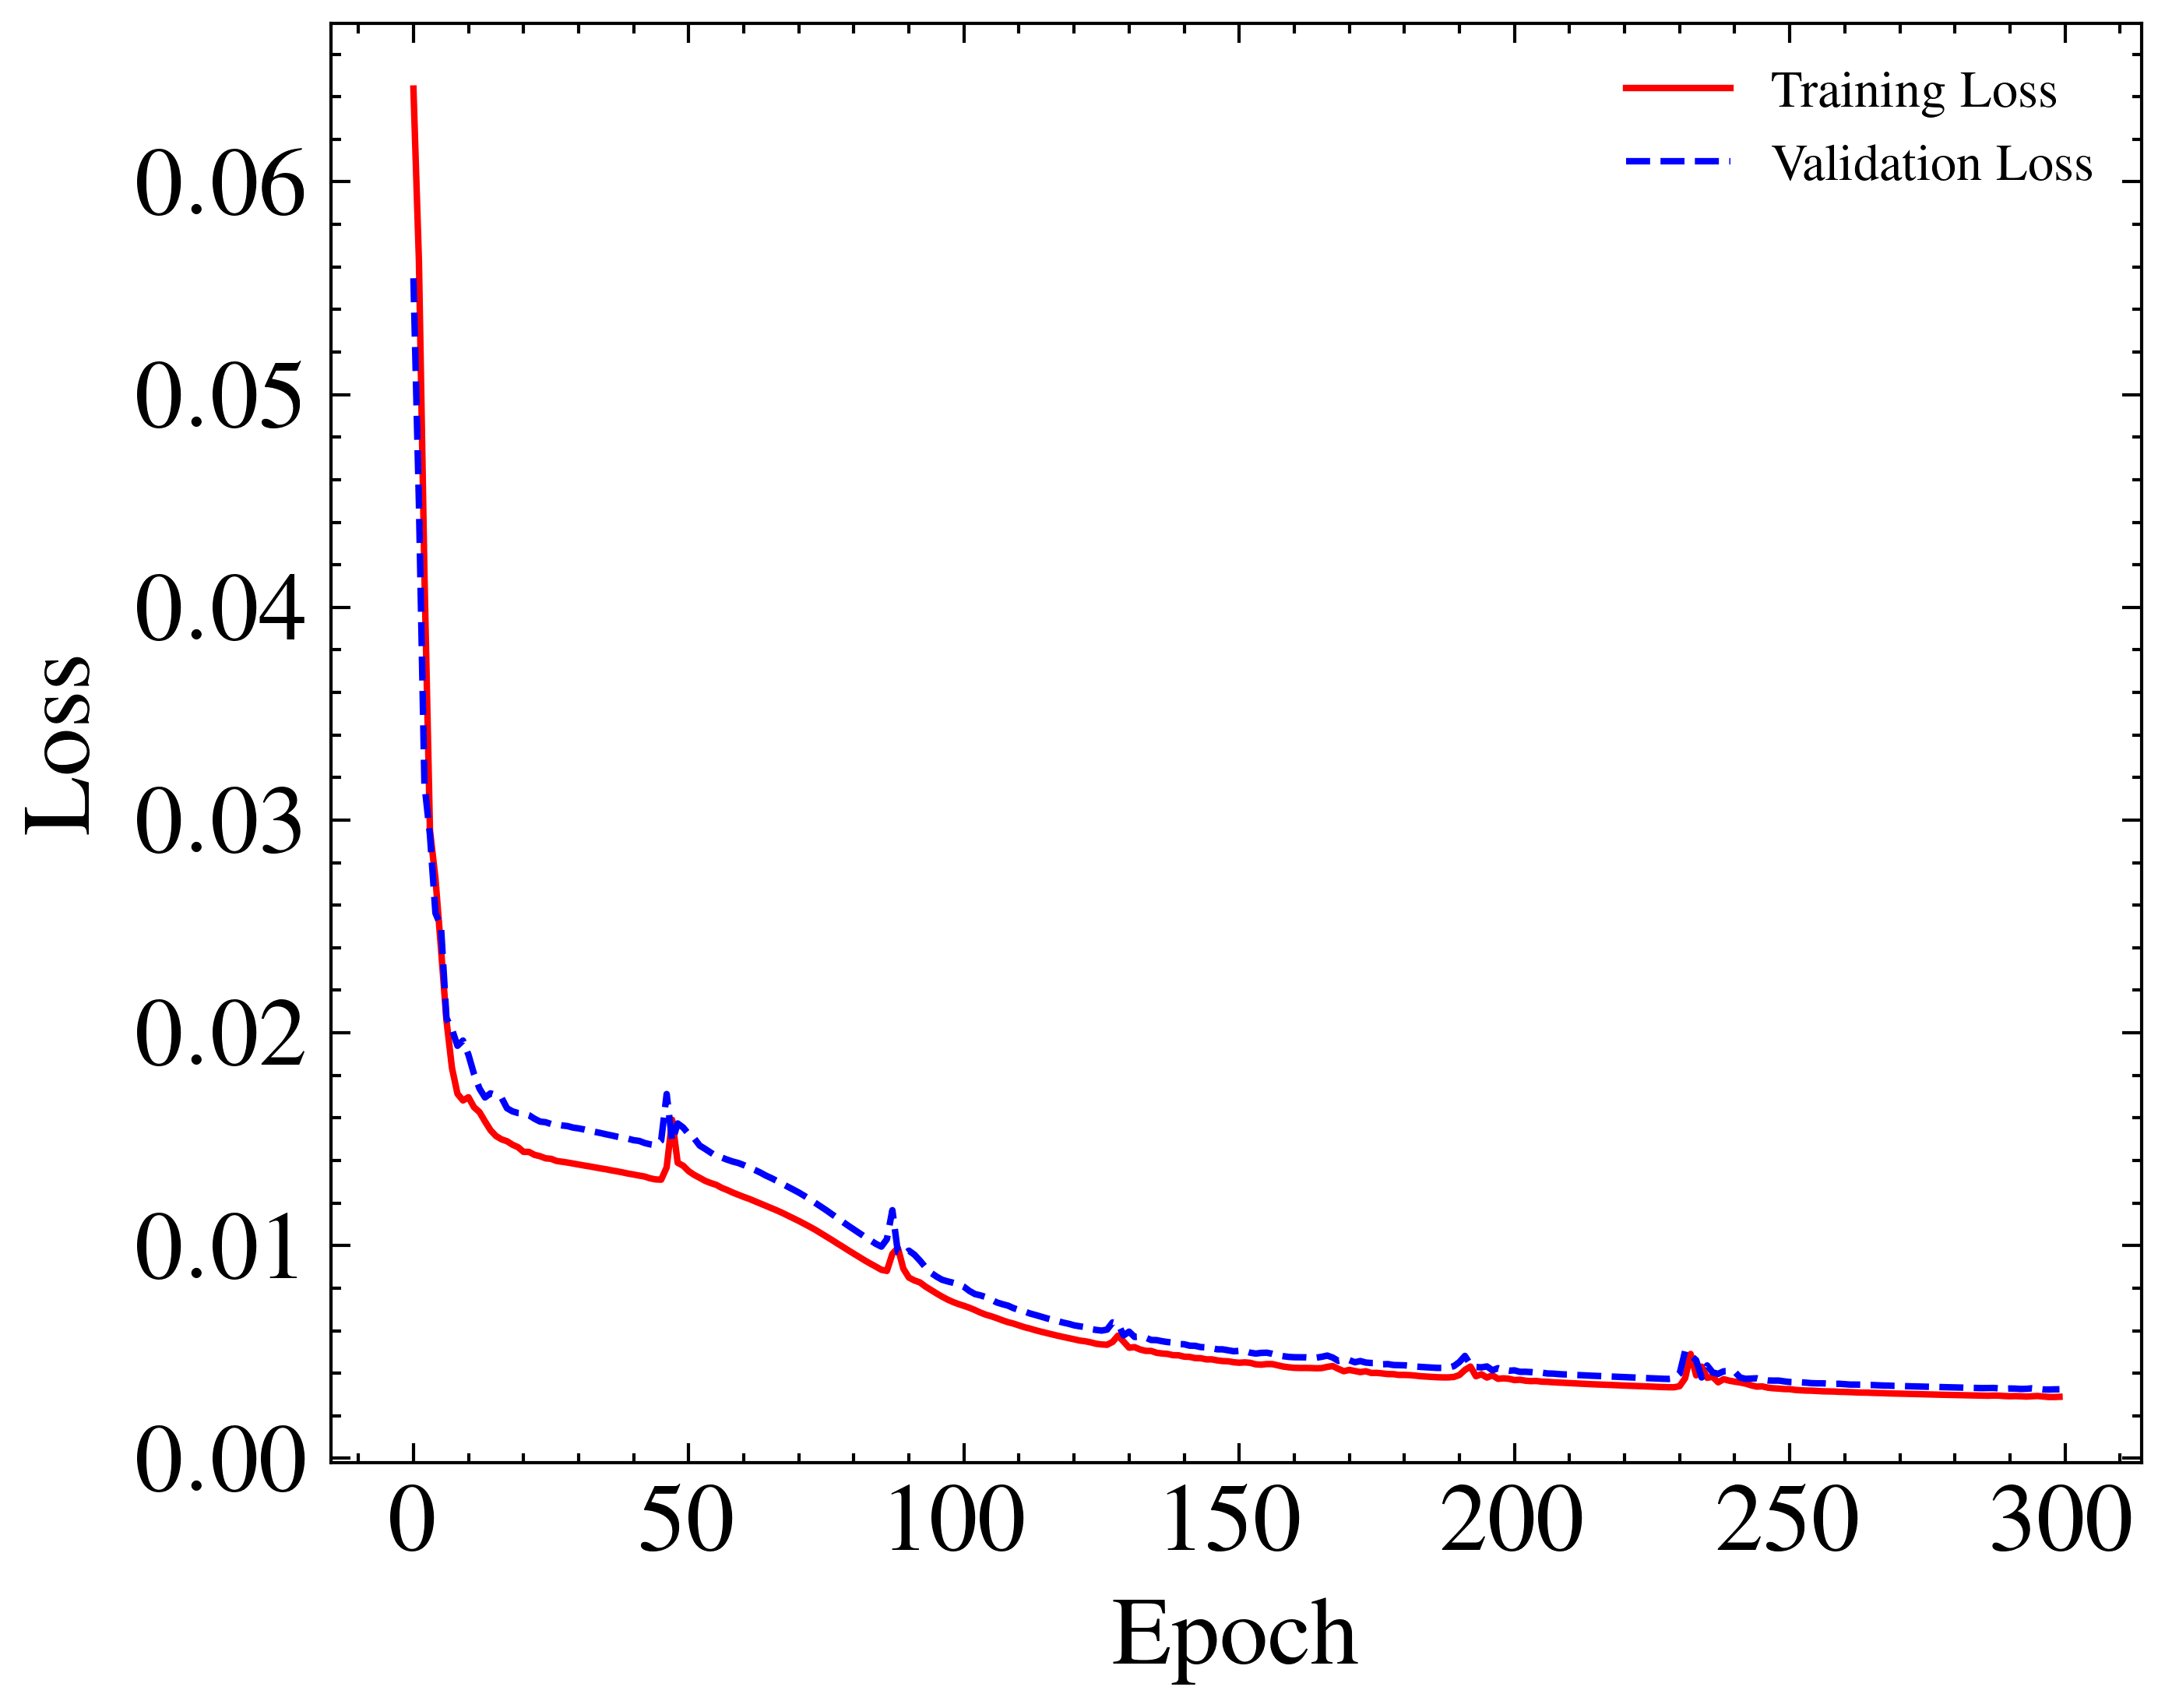

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots

# 配置绘图样式和参数
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = True
plt.style.use(['science', 'ieee'])
plt.rcParams['text.usetex'] = True

# 创建图形和坐标轴
fig, ax = plt.subplots(figsize=(5, 4))
plt.cla()  # 清除现有内容
plt.tick_params(labelsize=15)  # 设置刻度字体大小

# 绘制损失曲线（红色和蓝色）
ax.plot(np.arange(len(train_loss)), train_loss, color='red', label='Training Loss', linewidth=1)
ax.plot(np.arange(len(valid_loss)), valid_loss, color='blue', label='Validation Loss', linewidth=1)

# 设置正体的轴标签
ax.set_xlabel(r'$\mathrm{Epoch}$', fontsize=15)
ax.set_ylabel(r'$\mathrm{Loss}$', fontsize=15)

# 手动设置x轴刻度
plt.xticks(np.arange(0, len(train_loss) + 5, step=50))

# 添加图例（标注）
plt.legend(fontsize=8, loc='upper right')

# 指定保存路径和文件名
plot_path = r'D:\PycharmProjects\保存的参数\指纹参数\loss_raylu.eps'

# 保存为 EPS 文件
plt.savefig(plot_path, format='eps', bbox_inches='tight')
print(f"损失图已保存到 {plot_path}")

# 展示损失图
plt.show()
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


所有图像已保存至: ./rayluPics/


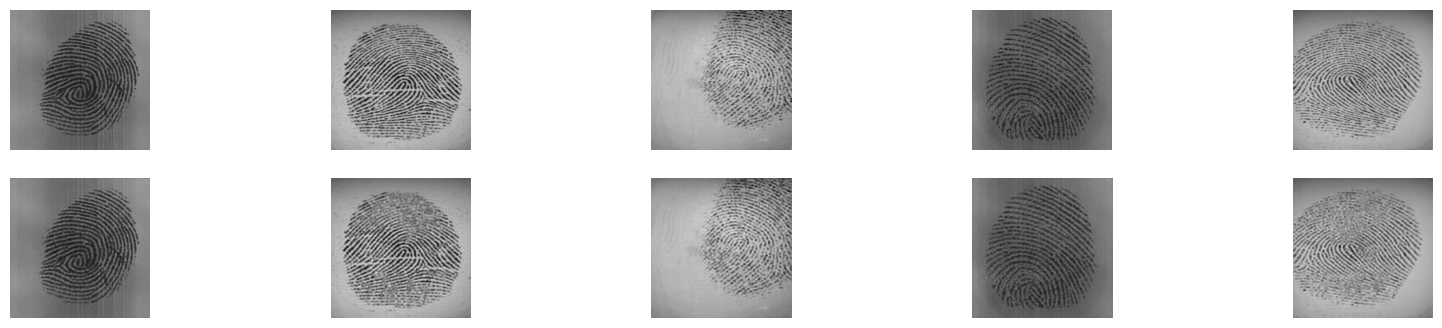

In [7]:

def save_and_visualize_reconstructions(model, data_loader, save_dir):
    """
    将所有验证集图像的原始和重建图像保存到指定文件夹，并展示前 5 张的对比。
    参数：
    - model: Autoencoder 模型
    - data_loader: 验证集的数据加载器
    - save_dir: 保存图像的文件夹路径（你需要提前创建好）
    """
    # 切换到评估模式
    model.eval()
    os.makedirs(save_dir, exist_ok=True)  # 如果文件夹不存在则创建
    img_counter = 0  # 图像计数器

    with torch.no_grad():
        # 遍历验证集批次
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            # 将张量转换为 NumPy 格式，并缩放到 [0, 255]
            inputs = (inputs.cpu().numpy() * 255).astype(np.uint8)
            outputs = (outputs.cpu().numpy() * 255).astype(np.uint8)

            # 遍历批次中的每一张图像
            for i in range(inputs.shape[0]):
                # 转换为 (H, W, C) 格式（适用于 PIL）
                original_img = np.transpose(inputs[i], (1, 2, 0))
                reconstructed_img = np.transpose(outputs[i], (1, 2, 0))

                # 保存原始和重建图像
                original_path = os.path.join(save_dir, f"original_{img_counter}.png")
                reconstructed_path = os.path.join(save_dir, f"reconstructed_{img_counter}.png")

                Image.fromarray(original_img).save(original_path)
                Image.fromarray(reconstructed_img).save(reconstructed_path)

                img_counter += 1  # 更新计数器

    print(f"所有图像已保存至: {save_dir}")

    # 展示前 5 张原始和重建图像的对比
    plt.figure(figsize=(20, 4))
    for i in range(5):
        # 加载已保存的图像
        original_img = Image.open(os.path.join(save_dir, f"original_{i}.png"))
        reconstructed_img = Image.open(os.path.join(save_dir, f"reconstructed_{i}.png"))

        # 显示原始图像
        plt.subplot(2, 5, i + 1)
        plt.imshow(original_img)
        plt.axis('off')

        # 显示重建图像
        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructed_img)
        plt.axis('off')

    plt.show()


# 使用你指定的文件夹路径保存和展示重建图像
save_dir ="./rayluPics/"  # 将此处替换为你创建的文件夹路径
save_and_visualize_reconstructions(autoencoder, valid_loader, save_dir)